In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
# filename: hmda_data_munging.py
"""
Created on Wed Mar 22 

@author: leimu
"""

import numpy as np
import pandas as pd


# Data Munging
def NumVarGroup(var, gname, gtype = 'bin', nbin = 10):
    """
    Group a numeric variable based on type and number of bins, return group labels
        
    ARGUMENTS: 
      var           The variable to be grouped
      gname         Rename the var group
      gtype: 
        'bin'       Equal length group
        'outlier'   Group 99% percentile into nbin-1 group and another outlier group
        'ebin'      Same number of records for each bin
      nbin          Number of bins
    """
    if gtype == 'bin':
        return pd.cut(var, nbin, precision = 0)
    if gtype == 'outlier':
        pctl = np.percentile(var, 99)
        bins = [x*pctl/(nbin-1) for x in range(nbin)] + [max(var)]
        return pd.cut(var, bins, precision = 0).rename(gname)  
    if gtype == 'ebin':
        return pd.qcut(var, nbin, precision = 0)   

def hmda_init(inst_file = 'prod/user/sam/coaf/adhoc/tjy118/data/HMDA_Data/2012_to_2014_institutions_data.csv', 
             loans_file = 'prod 2/user/sam/coaf/adhoc/tjy118/data/HMDA_Data/2012_to_2014_loans_data.csv'):
    """
    Read data files
    Merge the application data with institution data such that each loan application is assigned a “Respondent_Name”. 
    Create a new attribute that buckets “Loan_Amount_000” 
    """
    # Read csv files
    institutions_data = pd.read_csv(inst_file)
    loans_data = pd.read_csv(loans_file, low_memory=False)
    
    # Merge the application data with institution data assigned a “Respondent_Name”
    loans_data_merge = loans_data.merge(right = institutions_data[['Respondent_ID', 'Agency_Code', 'As_of_Year', 'Respondent_Name_TS']], on = ['Respondent_ID', 'Agency_Code', 'As_of_Year'], how = 'left').rename(columns={"Respondent_Name_TS": "Respondent_Name"})

    # Create a new attribute that buckets “Loan_Amount_000” into reasonable groups
    Loan_Amount_000_Group = NumVarGroup(loans_data['Loan_Amount_000'], gname = 'Loan_Amount_000_Group', gtype = 'outlier')    
    return pd.concat([loans_data_merge, Loan_Amount_000_Group], axis = 1)


def hmda_to_json(data, states = 'all', conventional_conforming = 'all'):
    """
    Export the expanded data set to disk for the states filtered by Conventional_Conforming_Flag.
      
    ARGUMENTS: 
      data                        The dataset
      states                      'VA', 'MD', 'WV', 'DE', 'DC'
      conventional_conforming     'Y', 'N'
    """
    if states == 'all':
        data_states = data
    else:
        data_states = data.ix[[x in states for x in data['State']],]
    if conventional_conforming == 'all':
        data_states.to_json('loans_data.JSON')
    else:
        data_states.ix[data_states['Conventional_Conforming_Flag'] == conventional_conforming,].to_json('loans_data.JSON')


In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
# filename: hmda_quality_check.py
"""
Created on Wed Mar 22 

@author: leimu
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


# Quality check for continous variables
def QC_missing(var):
    """
    Calculate the percentage of missing records
    """
    num_var = len(var)
    if sum(var.isnull()) == 0:
        print 'No missing values.'
        return False
    else:
        print 'Percentage of missing records is {0:.0f}%'.format(sum(var.isnull())*1.0/num_var *100)
        return True

def QC_outlier(var):
    """
    Check outliers for continuous numeric variables: 
        If the maximum/minimum is larger/smaller than mean +/- 3 * standard deviation, 
    then this variable has outliers   
    """
    if (max(var) > var.mean() + 3*var.std()) or (min(var) < var.mean() + 3*var.std()):
        print 'There are outliers!'
        return True
    else:
        print 'No outliers!'
        return False

def QC_histogram(var):
    """
    Plot histogram: 
    
    If the variable has outliers, take log transformation then plot.
    If the variable does not have outliers, plot it directly.
    """
    # Histogram
    plt.figure(1)
    var.plot.hist(alpha=0.5, bins = 200)
    plt.title(var.name + " Histogram")
    plt.xlabel(var.name)
    plt.ylabel("Frequency")
    
    # Log transformation histogram
    plt.figure(2)
    np.log(var+1).plot.hist(alpha=0.5, bins = 200)
    plt.title(var.name + " Histogram (Log transformation)")
    plt.xlabel(var.name + " Log transformation")
    plt.ylabel("Frequency")
    plt.show()

        
def QC_ContVar(var):
    """
    Quality check for continuous numeric variables: 
        missing value, outliers, distribution (histogram), descriptive statistics (mean/mode/range/percentile)
    """
    # missing value
    QC_missing(var)

    # Outliers
    QC_outlier(var)

    # Histogram
    QC_histogram(var)

    # Descriptive statistics (mean/mode/range/percentile)
    print 'Descriptive statistics:'
    print var.describe().round(0)
    
# Quality check for categorical variables
def QC_catg_hist(var):
    plt.figure(10)
    var.value_counts()[:10].plot(kind = 'bar')
    top10 = np.where(len(var.value_counts()) > 10, ' (Top 10)', '')
    plt.title(var.name + " Bar Plot" + str(top10))
    plt.ylabel("Frequency")

def QC_CatgVar(var):
    """
    Quality check for categorical variables: 
    """
    print '-'*30
    print 'Quality check for', var.name
    # Number of missing values
    QC_missing(var)

    # Number of different values 
    print 'Number of different values:', len(var.unique())

    # 10 most frequent values (if applicable)
    print '10 most frequent values:'
    print var.value_counts()[:10]
    
    # Plot 10 most frequent values (if applicable)
    QC_catg_hist(var)

    # Number of values that have only one record - outliers
    print 'Number of values that have only one record:', sum(var.value_counts() == 1)
    
    

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
# filename: hmda_visual_data.py
"""
Created on Wed Mar 22 

@author: leimu
"""

import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

def distance(origin, destination):
    """
    Calculate distance between origin and destination
    In this problem, the default destination is DC
      
    ARGUMENT: 
      origin            latitude, longitude list of origin
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

# Visualize metrics for market size by state and year
def state_year_plot(dataset, index = ['State'], function = 'sum', top = 5):
    state_year_loan_amt_agg = dataset.pivot_table(index = index, columns = 'As_of_Year', values = 'Loan_Amount_000', aggfunc = function)
    plt.figure(2)
    state_year_loan_amt_agg.sort_values(by = 2014, ascending = False).head(top).T.plot()
    plt.title(function.title()+' Loan Amount Trend')
    plt.xlabel('As of Year')
    plt.ylabel(function)
    plt.xticks(state_year_loan_amt_agg.columns)

In [4]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
# filename: hmda_outliers_cleaner.py
"""
Created on Wed Mar 22 

@author: leimu
"""

import numpy as np
# from hmda_quality_check import *

def outliers_cleaner(var):
    """
    Identify outliers and implement their values
    For continous variable, values larger/smaller than mean +/- 3 * standard deviation are identified as outliers. They are assigned to mean +/- 3 * standard deviation.
    For categorical variables, values with frequency less than 1% of all value frequencies are identified as outliers. They are assigned to 'OUTLIER GROUP'
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    if var.dtype in numerics:
        # numeric type
        outlier_flag = QC_outlier(var)
        if outlier_flag:
            # impute outlier as mean +/- 3 std
            var[var > var.mean() + 3*var.std()] = var.mean() + 3*var.std()
            var[var < var.mean() - 3*var.std()] = var.mean() - 3*var.std()
    else:
        var_cnt = var.value_counts()
        # Set a 1% percentile threshold
        var_cnt_01 = np.percentile(var_cnt, 0.01)
        if var_cnt_01 < sum(var_cnt)*0.001:
            print 'There are outliers!'
            outlier_values = list(var_cnt[var_cnt <= var_cnt_01].index)
            outlier_dict = {x: 'OUTLIER GROUP' for x in outlier_values}
            var = var.replace(outlier_dict)
        else:
            print 'No outliers!'    
    return var


In [5]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [6]:
# data munging
loans_data_init = hmda_init()
hmda_to_json(data = loans_data_init, states = ['VA', 'NY'], conventional_conforming = 'Y')


No missing values.
There are outliers!


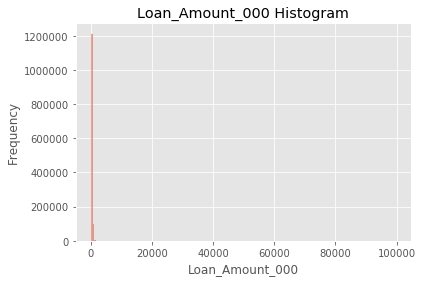

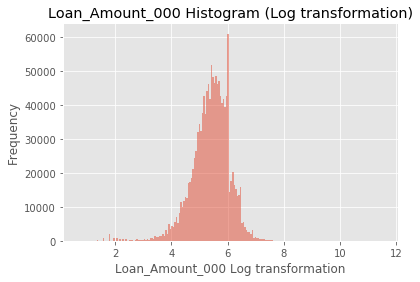

Descriptive statistics:
count    1321158.0
mean         290.0
std          966.0
min            1.0
25%          153.0
50%          235.0
75%          347.0
max        99625.0
Name: Loan_Amount_000, dtype: float64
------------------------------
Quality check for Respondent_Name
No missing values.
Number of different values: 1602
10 most frequent values:
WELLS FARGO BANK, NA           137060
QUICKEN LOANS                   66561
BANK OF AMERICA, N.A.           48506
BRANCH BANKING AND TRUST CO     47543
SUNTRUST MORTGAGE, INC          46798
JPMORGAN CHASE BANK, NA         44010
NFCU                            33971
GEORGE MASON MORTGAGE LLC       29021
PNC BANK N.A.                   26117
CITIBANK, N.A.                  23885
Name: Respondent_Name, dtype: int64
Number of values that have only one record: 241
Percentage of missing records is 9%
There are outliers!


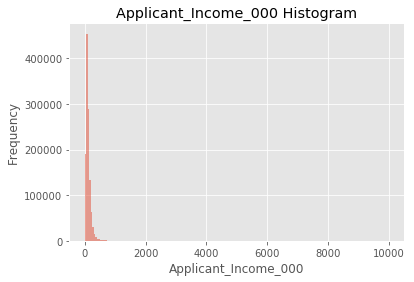

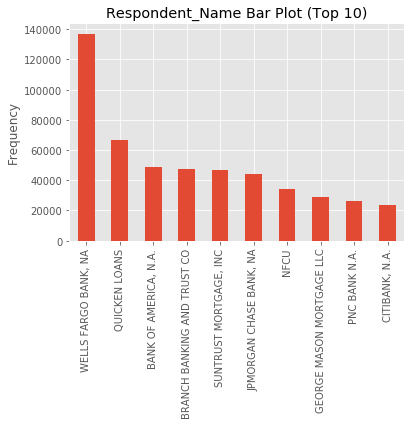

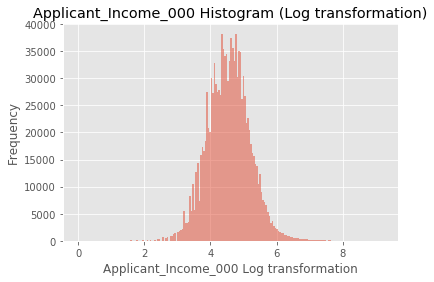

Descriptive statistics:
count    1203305.0
mean         118.0
std          123.0
min            0.0
25%           60.0
50%           94.0
75%          142.0
max         9999.0
Name: Applicant_Income_000, dtype: float64
------------------------------
Quality check for State
No missing values.
Number of different values: 5
10 most frequent values:
VA    679703
MD    452637
WV     77651
DE     61706
DC     49461
Name: State, dtype: int64
Number of values that have only one record: 0


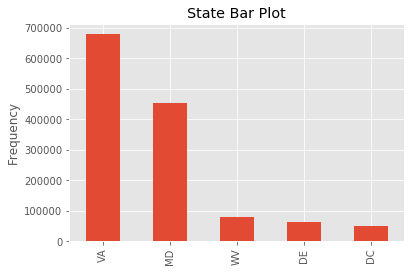

In [7]:
# quality check
QC_ContVar(var = loans_data_init['Loan_Amount_000'])
QC_CatgVar(loans_data_init['Respondent_Name'])

# Quality check for other variables
# Numeric variables
Applicant_Income_000 = pd.to_numeric(loans_data_init['Applicant_Income_000'], downcast='integer', errors='coerce')
QC_ContVar(Applicant_Income_000)
# Categorical Variables
QC_CatgVar(loans_data_init['State'])

As_of_Year                       2012      2013     2014  2012 GR  2013 GR  \
State Loan_Amount_000_Group                                                  
VA    (905, 99625]            9778405   9449353  9435182    -0.03    -0.00   
      (201.1, 301.7]         19052495  15347283  8960862    -0.19    -0.42   
      (301.7, 402.2]         18702744  14136354  8302254    -0.24    -0.41   
MD    (201.1, 301.7]         14766367  11789525  6981906    -0.20    -0.41   
VA    (100.6, 201.1]         12727228  11581137  6625157    -0.09    -0.43   

As_of_Year                   AVG GR  MAVG GR        2015F       2015FM  \
State Loan_Amount_000_Group                                              
VA    (905, 99625]            -0.02    -0.02 9,268,114.97 9,261,162.76   
      (201.1, 301.7]          -0.31    -0.48 6,145,380.18 4,695,781.70   
      (301.7, 402.2]          -0.33    -0.49 5,531,480.17 4,239,070.72   
MD    (201.1, 301.7]          -0.31    -0.47 4,800,916.66 3,694,562.45   
VA    (10

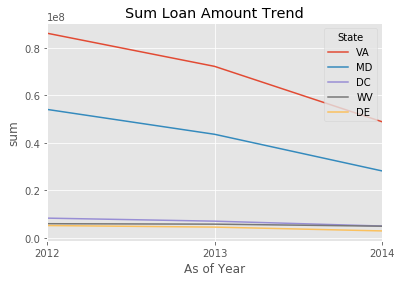

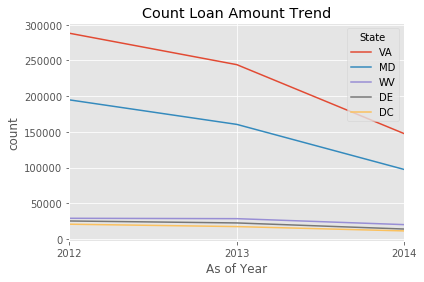

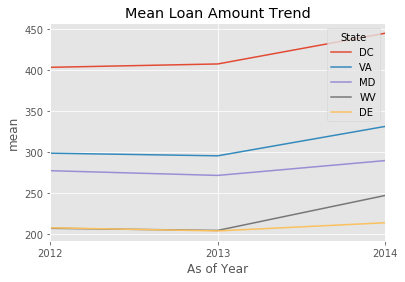

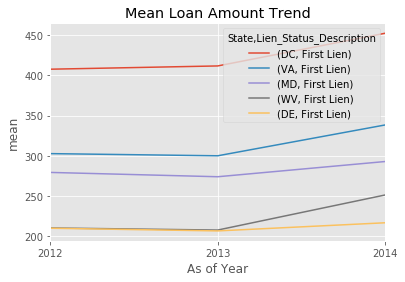

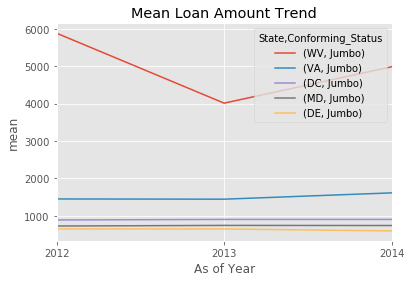

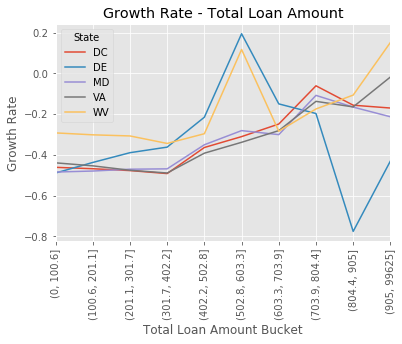

In [8]:
# Craft a visual data narrative
zip_lat_lon = pd.read_csv('zip_codes_states.csv')
county_lat_lon = zip_lat_lon[['state', 'county', 'latitude', 'longitude']].drop_duplicates(['state', 'county'])
county_lat_lon['county'] = county_lat_lon['county'].str.upper()
state_year_loan_amt_agg = loans_data_init.pivot_table(index = ['State', 'County_Name'], columns = 'As_of_Year', values = 'Loan_Amount_000', aggfunc = sum)
state_year_loan_amt_agg_10 = state_year_loan_amt_agg.sort_values(by = 2014, ascending = False)
county_loan = state_year_loan_amt_agg_10.merge(county_lat_lon, left_index = True, right_on = ['state', 'county'], how = 'left')


state_year_plot(dataset = loans_data_init, function = 'sum')
state_year_plot(dataset = loans_data_init, function = 'count')
state_year_plot(dataset = loans_data_init, function = 'mean')

state_year_plot(dataset = loans_data_init, index = ['State', 'Lien_Status_Description'], function = 'mean')
state_year_plot(dataset = loans_data_init, index = ['State', 'Conforming_Status'], function = 'mean')

state_year_loan_amt_agg = loans_data_init.pivot_table(index = ['State', 'Loan_Amount_000_Group'], columns = 'As_of_Year', values = 'Loan_Amount_000', aggfunc = sum)
state_year_loan_amt_agg['2012 GR'] = (state_year_loan_amt_agg[2013]-state_year_loan_amt_agg[2012])/state_year_loan_amt_agg[2012]
state_year_loan_amt_agg['2013 GR'] = (state_year_loan_amt_agg[2014]-state_year_loan_amt_agg[2013])/state_year_loan_amt_agg[2013]
state_year_loan_amt_agg['AVG GR'] = np.sqrt((1+state_year_loan_amt_agg['2012 GR'])*(1+state_year_loan_amt_agg['2013 GR']))-1
state_year_loan_amt_agg['MAVG GR'] = np.sqrt((1+state_year_loan_amt_agg['2012 GR'])*(1+state_year_loan_amt_agg['2013 GR'])**2)-1
state_year_loan_amt_agg['2015F'] = state_year_loan_amt_agg[2014]*(1+state_year_loan_amt_agg['AVG GR'])
state_year_loan_amt_agg['2015FM'] = state_year_loan_amt_agg[2014]*(1+state_year_loan_amt_agg['MAVG GR'])
state_year_loan_amt_agg['2015FA'] = (state_year_loan_amt_agg['2015F']+state_year_loan_amt_agg['2015FM'])/2
pd.options.display.float_format = '{:0,.2f}'.format
state_year_loan_amt_agg_F = state_year_loan_amt_agg.sort_values(by = '2015FA', ascending = False)
print state_year_loan_amt_agg_F.head()

state_year_loan_amt_agg_F['MAVG GR'].unstack().T.plot(rot = 90)
plt.title('Growth Rate - Total Loan Amount')
plt.xlabel('Total Loan Amount Bucket')
plt.ylabel('Growth Rate')

In [9]:
# Systematic tool for outliers
new_var = outliers_cleaner(var = loans_data_init['Respondent_Name'])

There are outliers!
